In [ ]:
pip install yfinance


Strategy Returns: 103.91%
Market Returns (Buy and Hold): 17.66%
Sharpe Ratio: 0.70
Maximum Drawdown: -54.23%


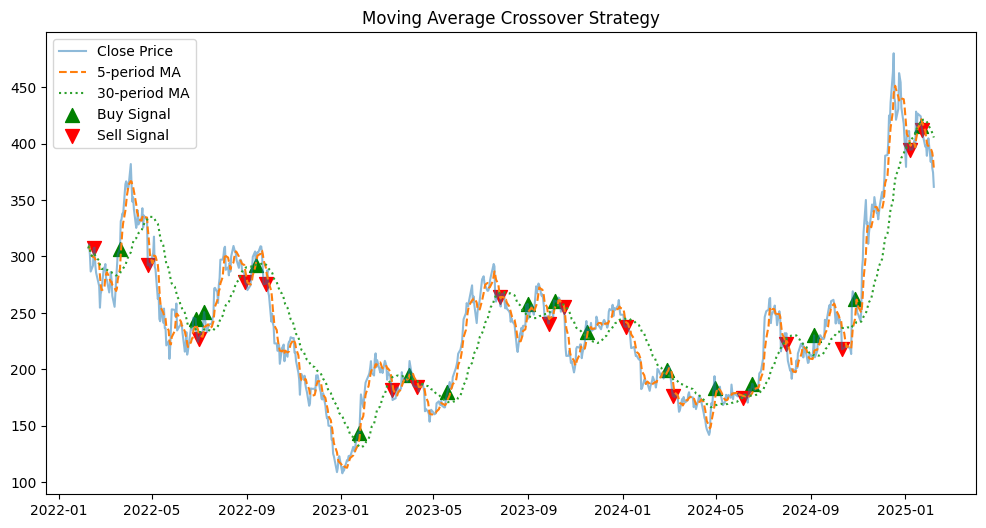

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime

# Calculate moving averages
def calculate_moving_averages(df, short_window, long_window):
    """
    Calculate short-term and long-term moving averages.
    """
    df['Short_MA'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
    df['Long_MA'] = df['Close'].rolling(window=long_window, min_periods=1).mean()
    return df



# Compute moving averages
def compute_moving_averages(df, short_window=5, long_window=30):
    """Compute short-term and long-term moving averages."""
    df['Short_MA'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
    df['Long_MA'] = df['Close'].rolling(window=long_window, min_periods=1).mean()
    return df

# Implement trading strategy
def implement_strategy(df):
    """Implement the moving average crossover strategy with proper signal holding."""
    df['Signal'] = 0  # Initialize signals

    # Buy: Short MA crosses above Long MA
    df.loc[(df['Short_MA'] > df['Long_MA']) & (df['Short_MA'].shift(1) <= df['Long_MA'].shift(1)), 'Signal'] = 1  # Long signal

    # Sell: Short MA crosses below Long MA
    df.loc[(df['Short_MA'] < df['Long_MA']) & (df['Short_MA'].shift(1) >= df['Long_MA'].shift(1)), 'Signal'] = -1  # Short signal

    # Hold the last signal until a new crossover occurs
    df['Signal'] = df['Signal'].replace(0, np.nan).ffill().fillna(0)

    return df


# Backtest the strategy
def backtest_strategy(df):
    """
    Backtest the strategy and calculate returns.
    """
    df['Returns'] = df['Close'].pct_change()
    df['Strategy_Returns'] = df['Returns'] * df['Signal'].shift(1)
    df['Cumulative_Returns'] = (1 + df['Strategy_Returns']).cumprod()
    df['Market_Return'] = df['Close'].pct_change().fillna(0)  # Daily returns
    df['Cumulative_Market_Return'] = (1 + df['Market_Return']).cumprod()  # Cumulative return
    return df

# Calculate performance metrics
def calculate_metrics(df):
    """
    Calculate performance metrics: total returns, Sharpe ratio, and maximum drawdown.
    """

    Market_Return = df['Cumulative_Market_Return'].iloc[-1] - 1
    total_returns = df['Cumulative_Returns'].iloc[-1] - 1
    sharpe_ratio = np.sqrt(252) * (df['Strategy_Returns'].mean() / df['Strategy_Returns'].std())

    # Maximum drawdown
    df['Peak'] = df['Cumulative_Returns'].cummax()
    df['Drawdown'] = (df['Cumulative_Returns'] - df['Peak']) / df['Peak']
    max_drawdown = df['Drawdown'].min()

    return Market_Return, total_returns, sharpe_ratio, max_drawdown


def plot_signals(df):
    plt.figure(figsize=(12,6))

    # Plot price and moving averages
    plt.plot(df.index, df['Close'], label='Close Price', alpha=0.5)
    plt.plot(df.index, df['Short_MA'], label='5-period MA', linestyle='dashed')
    plt.plot(df.index, df['Long_MA'], label='30-period MA', linestyle='dotted')

    # Identify first Buy/Sell signal per position
    buy_signals = df[(df['Signal'] == 1) & (df['Signal'].diff() != 0)].index  # First buy after change
    sell_signals = df[(df['Signal'] == -1) & (df['Signal'].diff() != 0)].index  # First sell after change

    # Plot Buy and Sell markers
    plt.scatter(buy_signals, df.loc[buy_signals, 'Close'], label='Buy Signal', marker='^', color='g', s=100)
    plt.scatter(sell_signals, df.loc[sell_signals, 'Close'], label='Sell Signal', marker='v', color='r', s=100)

    plt.title('Moving Average Crossover Strategy')
    plt.legend()
    plt.show()



# Main function
def main():
    # Parameters
    # Define the ticker symbol
    ticker_symbol = 'TSLA'  # Example: Apple Inc.

    # Get the ticker object
    ticker = yf.Ticker(ticker_symbol)

    # Fetch historical data
    df = ticker.history(period='3y', interval='1d')  # Fetches daily data for the past month

    # Calculate moving averages
    df = calculate_moving_averages(df, short_window=5, long_window=30)

    # Implement strategy
    df = implement_strategy(df)

    # Backtest strategy
    df = backtest_strategy(df)

    # Calculate performance metrics
    Market_Return, total_returns, sharpe_ratio, max_drawdown = calculate_metrics(df)

    # Print results
    print(f"Strategy Returns: {total_returns * 100:.2f}%")
    print(f"Market Returns (Buy and Hold): {Market_Return * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")

    plot_signals(df)

if __name__ == "__main__":
    main()

 #### **Follow-Up Questions**

**Question 1:** How would you optimize execution to reduce slippage?


**Answer:**

To optimize execution and reduce slippage, consider using limit orders. By setting a specific price for buying or selling an asset, limit orders allow trades to execute only at the desired price or better. This contrasts with market orders, which execute immediately at the best available price and can lead to unexpected price changes due to market volatility. This approach helps control execution costs and mitigates the effects of slippage.

**Question 2:** How would you modify the strategy to incorporate risk management measures?



**Answer:**


To incorporate risk management measures into the strategy, we can integrate stop-loss and take-profit orders. A stop-loss will automatically close a trade if the price moves against the position by a predetermined percentage to limit potential losses. Conversely, a take-profit order will close the trade once a target profit level is achieved, ensuring that gains are locked in before any market reversal occurs. These strategies are essential for managing risk and maintaining a disciplined trading approach.


**Question 3 :**  What other indicators could you use to improve the performance of the strategy?




**Answer :**

To enhance the performance of the moving average crossover strategy, we can use additional indicators to confirm signals and filter out false trades. The Relative Strength Index (RSI) can help identify overbought and oversold conditions, preventing entry into trades at extreme price levels. Additionally, the Average True Range (ATR) measures volatility and can be utilized to set adaptive stop-loss and take-profit levels.